<a href="https://colab.research.google.com/github/Praveszh/ULMFiT-for-US-Airline-Sentiment-Analysis/blob/master/ULMFiT_model_for_Twitter_US_Airlines_Sentiment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PROBLEM STATEMENT 

Our objective here is to fine-tune a ULMFiT model and use it for text classification on Twitter US-Airline Sentiment dataset. We will implement ULMFiT in this process.

##Twitter US-Airlines Sentiment
The following notebook demonstrate how to perform sentiment analysis using ULMFiT how travellers in February 2015 expressed their feelings on Twitter.

##Sentiment Analysis
Sentiment analysis is a Natural Language Processing (NLP) problem which aims to classify what is the sentiment associated with a given inputed text.

##ULMFiT
ULMFiT (Universal Language Model Fine-tuning) is a language model which was developed with inspiration from inductive transfer learning which is prevelant in computer vision IMAGENET. The basic idea is that a language model shouldn't have to relearn for each task in basic foundations of a given language (i.e. what is a valid word). Therefore, ULMFiT was trained on a large corpus in order to learn language and then we finetune the model for our specific task.

##SYSTEM SETUP
We will perform the python implementation on **Google Colab** instead of our local machines. Colab, or Google Colaboratory, is a free cloud service for running Python. One of the best things about it is that it provides **GPU**s and **TPU**s for free and hence, it is pretty handy for training deep learning models.

###IMPORTING LIBRARIES

Most of the popular libraries like pandas, numpy, matplotlib, nltk, and keras, come preinstalled with Colab. However, 2 libraries, PyTorch and fastai v1 (which we need in this exercise), will need to be installed manually. So, let’s load them into our Colab environment:

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [2]:
!pip install fastai

**EXPLORATORY DATA ANALYSIS (EDA) **

In [0]:
# Importing libraries for basic data exploration and visualization
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Importing Dataset
url = 'https://raw.githubusercontent.com/Praveszh/ULMFiT-for-US-Airline-Sentiment-Analysis/master/Tweets.csv'
Airline_tweets = pd.read_csv(url)
Airline_tweets.head()      

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
print(Airline_tweets.shape)

(14640, 15)


In [6]:
# Getting the length of the strings in each column.
# So,we can drop those columns for better view to understand the dataset
(len(Airline_tweets)-Airline_tweets.count())/len(Airline_tweets)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [7]:
# Dropping the several columns for the better view & understanding of the dataset

Airline_tweets.drop(Airline_tweets.columns[[2,4,6,8,11,12]], axis=1, inplace=True)
Airline_tweets.head()

,tweet_id,airline_sentiment,negativereason,airline,name,retweet_count,text,tweet_location,user_timezone
0,570306133677760513,neutral,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,NaN,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,Bad Flight,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,Can't Tell,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,Pacific Time (US & Canada)


In [8]:
# Analyzing the tweets by grouping airline and airline_sentiment

sentiment_polarity = Airline_tweets.groupby(["airline","airline_sentiment"]).size().unstack()
print(sentiment_polarity)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


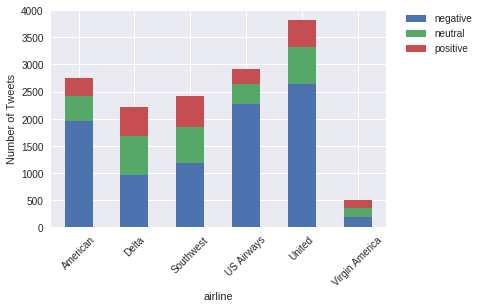

In [9]:
# Plotting sentiment_polarity of each airline

ax = sentiment_polarity.plot.bar(stacked=True)
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [10]:
# Crosstab for each negative reason and airlines

pd.crosstab(Airline_tweets.airline, Airline_tweets.negativereason, margins=True, margins_name="Total")

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines,Total
airline,,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34,1960
Delta,64,186,51,199,11,60,44,269,57,14,955
Southwest,90,159,162,391,14,38,61,152,90,29,1186
US Airways,104,246,189,811,11,123,122,453,154,50,2263
United,216,379,181,681,22,168,144,525,269,48,2633
Virgin America,19,22,18,60,4,5,28,17,5,3,181
Total,580,1190,847,2910,74,481,529,1665,724,178,9178


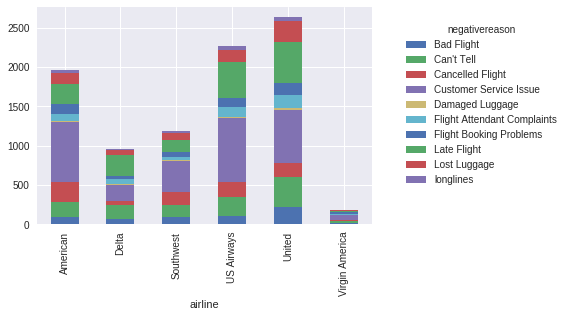

In [11]:
# Plotting a stacked bar graph for negative reasons and airlines

ax1 = pd.crosstab(Airline_tweets.airline, Airline_tweets.negativereason)
ax1.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1),title='negativereason',loc =2,borderaxespad=1.4)

**DATA PREPROCESSING **

In [12]:
# Adding a new column(label) assuming with values 
# POS:1,NEG:-1,NEUT:0
def label(x):
    if x=='negative':
        return -1
    elif x=='positive':
        return 1
    return 0
Airline_tweets['label'] = Airline_tweets['airline_sentiment'].apply(label)
Airline_tweets.head()

,tweet_id,airline_sentiment,negativereason,airline,name,retweet_count,text,tweet_location,user_timezone,label
0,570306133677760513,neutral,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,Eastern Time (US & Canada),0
1,570301130888122368,positive,NaN,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,Pacific Time (US & Canada),1
2,570301083672813571,neutral,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,Lets Play,Central Time (US & Canada),0
3,570301031407624196,negative,Bad Flight,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,NaN,Pacific Time (US & Canada),-1
4,570300817074462722,negative,Can't Tell,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,NaN,Pacific Time (US & Canada),-1


In [13]:
# We need only two columns(label,text) to work with:
# convert those columns into a new dataframe
df = pd.DataFrame(Airline_tweets[['label','text']])
df.head()

,label,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,0,@VirginAmerica I didn't today... Must mean I n...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...


**DATA CLEANING **

In [14]:
# Importing regular expression 

import re

# Removing all the mentions at the beginning of each tweet since and
# emoji's they have no role in sentiment.

def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)
df.text = df.text.apply(remove_mentions)
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-Z0-9,;:!?.\s]','',x)))
df.head(10)


,label,text
0,0,What said.
1,1,plus youve added commercials to the experienc...
2,0,I didnt today... Must mean I need to take ano...
3,-1,its really aggressive to blast obnoxious ente...
4,-1,and its a really big bad thing about it
5,-1,seriously would pay 30 a flight for seats tha...
6,1,"yes, nearly every time I fly VX this ear worm..."
7,0,Really missed a prime opportunity for Men Wit...
8,1,"Well, I didntbut NOW I DO! :D"
9,1,"it was amazing, and arrived an hour early. Yo..."


In [15]:
# Converting new dataframe into a CSV File
df.to_csv('texts.csv', index=False)

# Making a directory for repository
!mkdir repo

mkdir: cannot create directory ‘repo’: File exists


In [0]:
# Moving the text.csv file to repository 
!mv texts.csv /content/repo


#  ULMFiT

In [0]:
# Importing Libraries

import fastai
from fastai import *
from fastai.text import *
from fastai.core import *

In [0]:
# Assigning the path

path = Path('repo')

**LOADING OUR DATA INTO FASTAI**

To get a DataBunch quickly, there are also several factory methods depending on how our data is structured. They are all detailed in [text.data](https://docs.fast.ai/text.data.html), here we'll use the method [from_csv](https://docs.fast.ai/text.data.html#TextDataBunch.from_csv) of the [TextLMDataBunch](https://docs.fast.ai/text.data.html#TextLMDataBunch) (to get the data ready for a language model) and [TextClasDataBunch](https://) (to get the data ready for a text classifier) classes.
The TextLMDataBunch class creates a TextDataBunch suitable for training a language model. All the texts in the datasets are concatenated and the labels are ignored. Instead, the target is the next word in the sentence. 

In [0]:
# Building our DataBunches for LM fine-tuning and classification
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')

# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)


This does all the necessary preprocessing behind the scene. For the classifier, we also pass the vocabulary (mapping from ids to words) that we want to use: this is to ensure that [data_clas](https://) will use the same dictionary as [data_lm](https://).

Since this step can be a bit time-consuming, it's best to save the result with:

In [0]:
# To save a pickled copy of our TextDataBunches

data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
# Load the data

data_lm = load_data(path, fname='data_lm_export.pkl')
data_clas = load_data(path, fname='data_clas_export.pkl', bs=16)

In [22]:
# Tokenization

data_clas.show_batch()

text,target
xxbos xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059,-1
"xxbos i xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done",-1
"xxbos i have a xxup lh return business ticket from xxmaj den to xxmaj fra . xxmaj if i fly domestic with you , bag can be checked through to xxmaj fra , no need to claim",0
xxbos how do you go fr xxmaj silver xxmaj elite for two straight years to group 5 all the time ? i get no group 2 but maybe 3 or 4 ? xxmaj what s up,0
xxbos a month ago i had a flight booked but then had to xxmaj cancelled xxmaj flight it ... i m now xxmaj flight xxmaj booking xxmaj problems a separate flight for a different xxunk,0


**TRAINING A LANGUAGE MODEL**

One of the key insights of the ULMFiT model is to pretrain the language model on a large, more general dataset and to then fine tune on the target dataset. The ULMFiT paper chose to use the WikiText-103 dataset which is a large collection of English language wikipedia articles. This dataset is a pretty universal dataset for the English language so I'm going to use it for this task as well. There exists pretrained AWD-LSTMs for this dataset which I will use as the basis for my language model. language_model_learner automatically downloads and loads these pretrained weights through the AWD_LSTM model.

In [0]:
# Here we run language_model_learner and apply AWD_LSTM as the architecture of our network.

learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

**Discriminative Fine Tuning  [source](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb)**

From the ULMFiT paper, each layer of the model captures different types of information. Hence, it makes sense to fine-tune each layer differently, and this is done in ULMFiT after extensive empirical testing and implementation updates. Rather than change each layer manually, we can use the implemented ratios, but adapt the multiplier that influences the learning rate for each layer.

**1-cycle learning rate policy  [source](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb)**

In the fine-tuning stage, a 1-cycle learning rate policy is applied, which comes from this report by Leslie Smith. It is a modification of the cyclical learning rate policy, which has been around for a long time, but the 1-cycle policy allows a large initial learning rate ($LR_{max}=10^{-3}$, for example), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. In the ULMFiT implementation, this 1-cycle policy has been tweaked and is referred to as slanted triangular learning rate.

In [24]:
# Here we apply the 1-cycle learning rate policy
# 1e-2 is the max learning rate

learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.214099,4.489073,0.219062,00:20


For the language model fine tuning, we generally stick to the default values given in the ULMFiT paper/fasti.ai tutorials. In particular, the drop_mult and moms arguments are left as default. Cycle length (cyc_len) and learning rate (max_lr) are optimised based on validation set performance (and the lr_find() function for learning rate) since our dataset is quite different to the IMDB dataset that ULMFiT was originally trained on.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


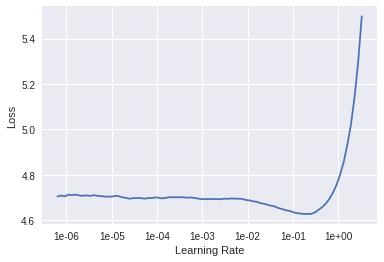

In [25]:
learn_lm.lr_find()
learn_lm.recorder.plot()

Like a computer vision model, we can then unfreeze the model and fine-tune it.

In [26]:
# all layers now trainable

learn_lm.unfreeze() 

# tried 10 epochs to get low validation loss

learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.564580,4.287525,0.236994,00:26
1,4.395458,4.125055,0.254732,00:26
2,4.237004,4.019881,0.265655,00:26
3,4.077517,3.947567,0.271696,00:26
4,3.934083,3.901733,0.277232,00:26
5,3.814389,3.878706,0.278914,00:26
6,3.706763,3.862193,0.282158,00:26
7,3.618165,3.857937,0.281994,00:26
8,3.572353,3.856980,0.282976,00:26
9,3.539821,3.856796,0.283214,00:26


In [27]:
learn_lm.predict("The flight is",n_words=10)

'The flight is giving birth onto her daughter 50 year old .'

That is pretty amazing! The model understands grammar and punctuation, and is using specific words in the right context.

In [0]:
# Saving the language model(LM) so we can load it later

learn_lm.save_encoder('ft_enc')

**TRAINING A CLASSIFIER**

We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line.

In [0]:
# After the LM is fine-tuned on the target task, we run the text_classifier_learner to start training the classifier
# on the target task (classification of tweets)

learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [0]:
# we load the fine-tuned LM as we are going to run further fine-tuning over the classifier

learn_clas.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


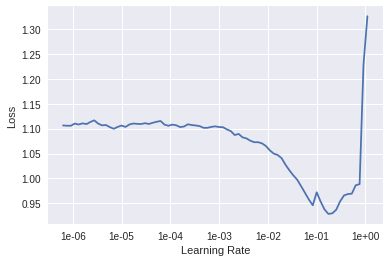

In [31]:
learn_clas.lr_find()
learn_clas.recorder.plot()

In [32]:
# we apply the 1-cycle learning rate policy again to train the classifier in 5 epochs.

learn_clas.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.681023,0.539554,0.796859,00:38
1,0.653090,0.524977,0.791055,00:37
2,0.636743,0.508546,0.799932,00:38
3,0.632282,0.492367,0.799590,00:37
4,0.593272,0.496460,0.807784,00:38


**Gradual unfreezing  [source](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb)**

Rather than training all the layers at once during classification, the layers are "frozen" and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as catastrophic forgetting (by fine-tuning all layers too aggressively).

In [33]:
# We first freeze everything except the last two layers and then start fine-tuning for 3 epochs

learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(3, slice(5e-3/2, 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.606281,0.500535,0.803687,00:43
1,0.589732,0.466042,0.815978,00:43
2,0.529693,0.453538,0.823489,00:43


In [34]:
# All the layers are unfreezed and we apply fine-tuning one last time.

learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.515769,0.444724,0.827928,01:27


In [35]:
# Predicting a Positive tweet

learn_clas.predict("Had to change my flight at the last second tonight, and the customer service was great as well as.Thank you @Delta")

(Category 1, tensor(2), tensor([0.1545, 0.0254, 0.8200]))

In [36]:
# Predicting a Negative tweet

learn_clas.predict("I'm never flying you again, worst response from customer service")

(Category -1, tensor(0), tensor([0.9966, 0.0018, 0.0016]))

In [37]:
# Predicting a Neutral tweet

learn_clas.predict("any plans to start flying directly from Bangalore to Dubai,@American ")

(Category 0, tensor(1), tensor([0.0144, 0.9844, 0.0013]))

**SUMMARY**

In this project, we built an classification pipeline usig ULMFiT approach in fastai.text library to analyze the sentiment of US-Airlline Tweets.We were able to achieve good accuracy by fine-tuning the model in two different stages : fine-tuning the LM for our target task and fine-tuning the classifier on the target task.

Finally, the ULMFiT model continued to learn the sentiment label and achieved its best accuracy of **0.827928** and some predictions for Positive, Negative and Neutral Tweets done by our model is worth satisfying.

####REFERENCE
https://course.fast.ai/index.html

https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde

